- https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/blob/main/PyTorch/Burgers'%20Equation/Burgers.ipynb

In [12]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


In [16]:
data = scipy.io.loadmat('burgers_shock.mat')
x = data['x']               # 256 points between -1 and 1 [256x1]
t = data['t']               # 100 time points between 0 and 1 [100x1] 
usol = data['usol']         # solution of 256x100 grid points

X, T = np.meshgrid(x, t)    # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
print(x.shape, t.shape)
print(X.shape, t.shape)
print("usol", usol.shape)

(256, 1) (100, 1)
(100, 256) (100, 1)
usol (256, 100)


In [18]:
''' X_u_test = [X[i],T[i]] [25600, 2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

u_true = usol.flatten()[:, None] 
print("u_true", u_true.shape)

u_true (25600, 1)


In [42]:
#Initial Condition at t = 0
leftedge_x = np.hstack((X[0, :][:, None], T[0, :][:, None]))
leftedge_u = usol[:, 0][:, None]
print("leftedge:  ", leftedge_x.shape, leftedge_u.shape)

#Boundary Condition at x = -1
bottomedge_x = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
bottomedge_u = usol[-1, :][:, None]
print("bottomedge:", bottomedge_x.shape, bottomedge_u.shape)

#Boundary Condition at x = 1
topedge_x = np.hstack((X[:, -1][:, None], T[:, 0][:, None]))
topedge_u = usol[0, :][:, None]
print("topedge    ", topedge_x.shape, topedge_u.shape)

all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]
print("all", all_X_u_train.shape, all_u_train.shape)

leftedge:   (256, 2) (256, 1)
bottomedge: (100, 2) (100, 1)
topedge     (100, 2) (100, 1)
all (456, 2) (456, 1)


In [51]:
N_u = 100       # Total number of data points for 'u'
N_f = 10000     # Total number of collocation points

#choose random N_u points for training
idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
u_train = all_u_train[idx,:]      #choose corresponding u
print(X_u_train.shape, u_train.shape)

## Collocation Points
# Latin Hypercube sampling for collocation points
# N_f sets of tuples(x, t)
lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1.0])
X_f_train = lb + (ub - lb)*lhs(2, N_f)
print(X_f_train.shape)

X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points
print(X_f_train.shape)

(100, 2) (100, 1)
(10000, 2)
(10100, 2)


In [94]:
class Sequentialmodel(nn.Module):

    def __init__(self, layers):
        super().__init__()

        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0

        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        # preprocessing input
        x = (x - l_b)/(u_b - l_b) #feature scaling

        #convert to float
        a = x.float()

        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)

        a = self.linears[-1](a)
        return a

    def loss_BC(self,x,y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u

    def loss_PDE(self, x_to_train_f):
        nu = 0.01/np.pi

        x_1_f = x_to_train_f[:, [0]]
        x_2_f = x_to_train_f[:, [1]]

        g = x_to_train_f.clone()
        g.requires_grad = True

        u = self.forward(g)
        u_x_t = autograd.grad(u, g, torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        u_xx_tt = autograd.grad(u_x_t, g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]

        u_x = u_x_t[:,[0]]
        u_t = u_x_t[:,[1]]
        u_xx = u_xx_tt[:,[0]]

        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx
        loss_f = self.loss_function(f, f_hat)
        return loss_f

    def loss(self, x, y, x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)

        loss_val = loss_u + loss_f

        return loss_val

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(X_u_train, u_train, X_f_train)
        loss.backward()
        self.iter += 1

        if self.iter % 100 == 0:
            test_loss, _ = PINN.test()
            print(f"loss: {loss.item():.2e}, error_vec: {test_loss.item():.2e}")
        return loss

    def test(self):
        u_pred = self.forward(X_u_test_tensor)
        error_vec = torch.linalg.norm((u - u_pred),2)/torch.linalg.norm(u, 2)        # Relative L2 Norm of the error (Vector)
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(256, 100),order='F')
        return error_vec, u_pred

In [ ]:
# 'Generate Training data'
# N_u = 100 #Total number of data points for 'u'
# N_f = 10_000 #Total number of collocation points
# X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)

X_f_train_np_array = X_f_train
X_u_train_np_array = X_u_train
u_train_np_array = u_train

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

TypeError: expected np.ndarray (got Tensor)

In [ ]:
# ## L-BFGS Optimizer
# layers = np.array([2, 20, 20, 20, 20, 20, 20, 20, 20, 1])
# PINN = Sequentialmodel(layers).to(device)
# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1,
#                               max_iter = 250,
#                               max_eval = None,
#                               tolerance_grad = 1e-05,
#                               tolerance_change = 1e-09,
#                               history_size = 100,
#                               line_search_fn = 'strong_wolfe')

# start_time = time.time()
# optimizer.step(PINN.closure)
# elapsed = time.time() - start_time
# print('Training time: %.2f' % (elapsed))

0.0891849547624588 1.1480246782302856
0.060737378895282745 1.1992253065109253
0.026348408311605453 1.3119443655014038
Training time: 20.78


In [139]:
## Adam Optimizer
layers = np.array([2, 20, 20, 20, 20, 1])
PINN = Sequentialmodel(layers).to(device)
optimizer = optim.Adam(PINN.parameters(), lr=0.001)
n_epochs = 5000

start_time = time.time()
for epoch in range(1, n_epochs + 1):

    loss = PINN.loss(X_u_train, u_train, X_f_train)

    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss.backward() #backprop
    optimizer.step()

    if epoch % (n_epochs // 10) == 0:
        error_vec, _ = PINN.test()
        print(f"[{epoch:4d}/{n_epochs}] loss: {loss.item():.2e}, error {error_vec.item():.2e}")

elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

[ 500/5000] loss: 6.86e-02, error 1.17e+00
[1000/5000] loss: 4.91e-02, error 1.22e+00
[1500/5000] loss: 2.73e-02, error 1.29e+00
[2000/5000] loss: 1.42e-02, error 1.34e+00
[2500/5000] loss: 9.84e-03, error 1.36e+00
[3000/5000] loss: 7.92e-03, error 1.38e+00
[3500/5000] loss: 6.63e-03, error 1.38e+00
[4000/5000] loss: 5.17e-03, error 1.39e+00
[4500/5000] loss: 4.26e-03, error 1.39e+00
[5000/5000] loss: 3.70e-03, error 1.40e+00
Training time: 77.47


(256, 100)


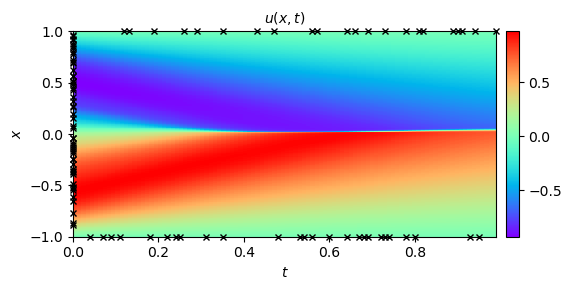

In [140]:
with torch.no_grad():
    u_pred = PINN(X_u_test_tensor)
u_pred = u_pred.cpu().detach().numpy().reshape(100, 256).T
print(u_pred.shape)

fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
            extent=[T.min(), T.max(), X.min(), X.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1].cpu(), X_u_train[:, 0].cpu(), 'kx',  markersize = 5, clip_on = False)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$u(x,t)$', fontsize = 10)

fig.tight_layout()
plt.show()

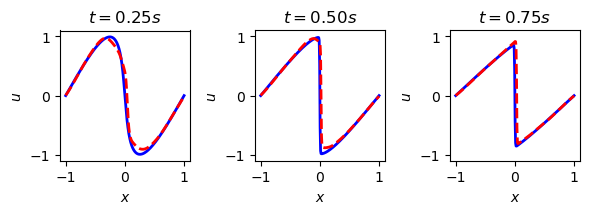

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(6, 3))
ax1.plot(x, usol.T[25,:], 'b-', lw=2, label='Exact')
ax1.plot(x, u_pred.T[25,:], 'r--', lw=2, label='Prediction')
ax1.set_title('$t = 0.25s$')

ax2.plot(x, usol.T[50,:], 'b-', lw=2, label='Exact')
ax2.plot(x, u_pred.T[50,:], 'r--', lw=2, label='Prediction')
ax2.set_title('$t = 0.50s$')

ax3.plot(x, usol.T[75,:], 'b-', lw=2, label='Exact')
ax3.plot(x, u_pred.T[75,:], 'r--', lw=2, label='Prediction')
ax3.set_title('$t = 0.75s$')

for ax in (ax1, ax2, ax3):
    # ax.legend(fontsize=6)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    
fig.tight_layout()
plt.show()